Proprietary content. ©Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited

# Semantic Segmentaion using UNet

---



## The Oxford-IIIT Pet Dataset
Omkar M Parkhi, Andrea Vedaldi, Andrew Zisserman and C. V. Jawahar have created a 37 category pet dataset with roughly 200 images for each class. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.

Link to dataset: http://www.robots.ox.ac.uk/~vgg/data/pets/

Firstly, let's select TensorFlow version 2.x in colab

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

### Load the dataset

As we are using google colab, we need to mount the google drive to load the data file

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Add path to the folder where your dataset files are

In [0]:
project_path = '/content/drive/My Drive/CV/Semantic Segmentation/'

All our images are in the zip file so we need to extract the contents of this file

In [0]:
images_zip_path = project_path + "images.zip"

from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

### Define the neccessary parameters

In [0]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

TRAIN_CSV = project_path + "train.csv"
VALIDATION_CSV = project_path + "validation.csv"

### Creating training data

In [0]:
import numpy as np
import csv
import cv2

with open(TRAIN_CSV, "r") as file:

  # Create an empty array for storing mask details.
  y_train = np.zeros((sum(1 for line in file), HEIGHT_CELLS, WIDTH_CELLS))
  print("y_train_shape:", y_train.shape)
  X_train_path = []
  file.seek(0)

  data = csv.reader(file, delimiter=',')

  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
        row[i+1] = int(r)

    path, image_height, image_width, x0, y0, x1, y1, _, _ = row

    path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
    path_mask = path.replace('.jpg','.png')

    mask_img = cv2.imread(path_mask)
    mask_img = (mask_img!=2)*1.0
    mask_img = cv2.resize(mask_img, (28, 28))
    mask_img = 1.0*(mask_img[:,:,0]>0.2)

    y_train[index,:,:] = np.squeeze(mask_img)
  
    X_train_path.append(path)

y_train_shape: (3006, 28, 28)


In [0]:
X_train_path[:5]

['./images/Abyssinian_1.jpg',
 './images/Abyssinian_10.jpg',
 './images/Abyssinian_100.jpg',
 './images/Abyssinian_101.jpg',
 './images/Abyssinian_102.jpg']

#### Let's visualize some training examples

First example

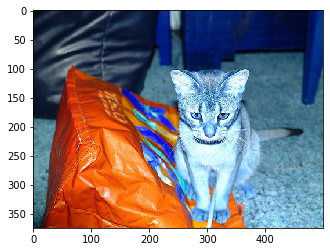

In [0]:
import matplotlib.pyplot as plt
plt.imshow(cv2.imread(X_train_path[6]))

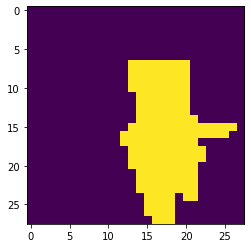

In [0]:
plt.imshow(y_train[6])

Second example

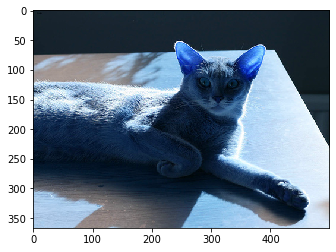

In [0]:
plt.imshow(cv2.imread(X_train_path[17]))

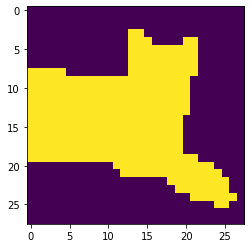

In [0]:
plt.imshow(y_train[17])

#### Preprocess the training feature images and convert them into an array which is compatable with Mobilenet

In [0]:
X_train = X_train_path

In [0]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

for i, f in enumerate(X_train_path):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_train[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [0]:
X_train = np.array(X_train)
X_train.shape

(3006, 224, 224, 3)

### Creating validation data

In [0]:
with open(VALIDATION_CSV, "r") as file:
  y_val = np.zeros((sum(1 for line in file), HEIGHT_CELLS, WIDTH_CELLS))
  print(y_val.shape)
  X_val_path = []
  file.seek(0)

  data = csv.reader(file, delimiter=',')

  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
        row[i+1] = int(r)

    path, image_height, image_width, x0, y0, x1, y1, _, _ = row

    path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
    path_mask = path.replace('.jpg','.png')

    mask_img = cv2.imread(path_mask)
    mask_img = (mask_img!=2)*1.0
    mask_img = cv2.resize(mask_img, (28, 28))
    mask_img = 1.0*(mask_img[:,:,0]>0.2)
    y_val[index,:,:] = np.squeeze(mask_img)
    
    X_val_path.append(path)

(680, 28, 28)


#### Let's visualize some validation examples

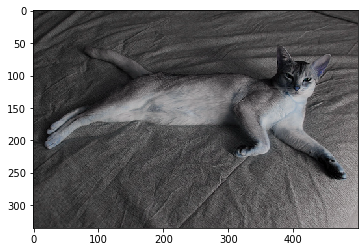

In [0]:
plt.imshow(cv2.imread(X_val_path[6]))

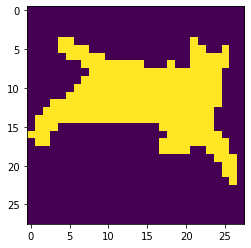

In [0]:
import matplotlib.pyplot as plt
plt.imshow(y_val[6])

#### Preprocess the validation feature images and convert them into an array which is compatable with Mobilenet

In [0]:
X_val = X_val_path

In [0]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

for i, f in enumerate(X_val_path):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_val[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [0]:
X_val = np.array(X_val)
X_val.shape

(680, 224, 224, 3)

### Let's create our model now

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((HEIGHT_CELLS, WIDTH_CELLS))(x)

    return Model(inputs=model.input, outputs=x)

#### Define dice coefficient

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

#### Define loss function

In [0]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Create the model and print summary

In [0]:
model = create_model(False)
model.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

### Compile the model
- Define optimizer
- Define metrics
- Define loss

In [0]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

### Fit the model

In [0]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=1, batch_size=32, verbose=1)

Train on 3006 samples, validate on 680 samples
  32/3006 [..............................] - ETA: 3:36

KeyboardInterrupt: ignored

### Let's do predictions on the model we trained

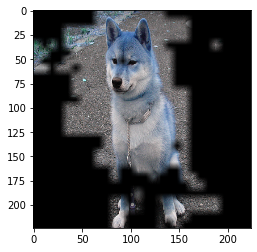

In [0]:
import matplotlib.pyplot as plt
filename = './images/shiba_inu_163.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

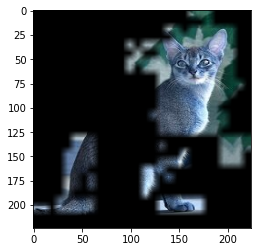

In [0]:
import matplotlib.pyplot as plt
filename = './images/Abyssinian_13.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

### Now, let's use pretrained weights

In [0]:
WEIGHTS_FILE = project_path + "model-0.71.h5"
THRESHOLD = 0.8
EPSILON = 0.02

model = create_model()
model.load_weights(WEIGHTS_FILE)

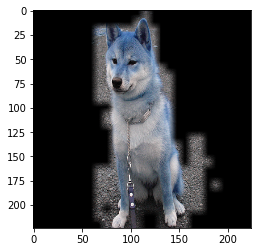

In [0]:
filename = './images/shiba_inu_163.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

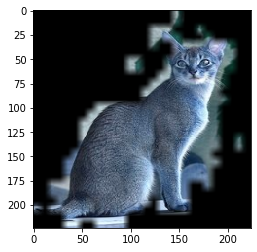

In [0]:
import matplotlib.pyplot as plt
filename = './images/Abyssinian_13.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)